In [108]:
# Model design
import agentpy as ap
import numpy as np


# Visualization
import matplotlib.pyplot as plt
import IPython

In [109]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [110]:
class Car(ap.Agent):
    def setup(self):
        self.direction = np.array([0, 0])  # x | y
        self.velocity = 0.0  # float
        self.max_velocity = 10.0
        self.my_traffic_lights = []

    def put_traffic_lights(self):
        for i in range(len(self.model.traffic_lights)):
            if (self.model.traffic_lights[i].direction == self.direction):
                self.my_traffic_lights.push(self.model.traffic_lights[i])
        print(self.my_traffic_lights)

    def update_position(self):
        self.model.avenue.move_by(self, np.multiply(self.direction, self.velocity))

    def update_velocity(self):
        for traffic_light in self.my_traffic_lights:
            distance = abs(self.model.avenue.positions(traffic_light)[1] - self.model.avenue.positions(self)[1])
            if(distance < 50 and traffic_light.state == 0):
                self.velocity = 0.0
            else:
                self.velocity = self.max_velocity




In [111]:
class Traffic_Light(ap.Agent):
    def setup(self):
        self.direction = np.array([0, 0])  # x | y
        self.state = 0  # 0: green | 1: yellow | 2: red
        self.green_duration = 0
        self.yellow_duration = 0
        self.red_duration = 0

    def update_state(self, t):
        if t < self.green_duration:
            self.state = 0
        elif t < self.green_duration + self.yellow_duration:
            self.state = 1
        else:
            self.state = 2

In [112]:
class Model(ap.Model):
    def setup(self):
        # Init Space
        self.avenue = ap.Space(self, shape=(self.p.size, self.p.size), torus=True)

        # Init Agents
        self.cars = ap.AgentList(self, self.p.population, Car)
        self.traffic_lights = ap.AgentList(self, 2, Traffic_Light)

        # Set traffic lights duration on each state
        self.traffic_lights.green_duration = self.p.green_duration
        self.traffic_lights.yellow_duration = self.p.yellow_duration
        self.traffic_lights.red_duration = self.p.red_duration

        # This variable is used to change the traffic lights state
        self.traffic_lights_max_cycle = self.p.green_duration + self.p.yellow_duration + self.p.red_duration


        # Add agent to model
        self.avenue.add_agents(self.traffic_lights)
        self.avenue.add_agents(self.cars)

        traffic_lights_x_offset = 30
        traffic_lights_y_offset = 60

        ## Set position of Traffic_Light
        self.avenue.move_to(self.traffic_lights[0],
                            [self.p.size * 0.5 - traffic_lights_x_offset, self.p.size * 0.5 - traffic_lights_y_offset])
        self.avenue.move_to(self.traffic_lights[1],
                            [self.p.size * 0.5 + traffic_lights_x_offset, self.p.size * 0.5 + traffic_lights_y_offset])

        ## Set Traffic_Light direction 
        self.traffic_lights[0].direction =  np.array([0, -1])
        self.traffic_lights[1].direction =  np.array([0, 1])

        ## Set position of Car
        for i in range(len(self.cars)):
            car = self.cars[i]
            car.put_traffic_lights()
            # Right
            if (i % 2 == 0):
                car.direction = np.array([0, 1])
                self.avenue.move_by(car, [self.p.size * 0.5 + traffic_lights_x_offset, 0])
            # Left
            else:
                car.direction = np.array([0, -1])
                self.avenue.move_by(car, [self.p.size * 0.5 - traffic_lights_x_offset, self.p.size])
                
    def step(self):
        traffic_lights_cycle_t = self.t % self.traffic_lights_max_cycle

        self.cars.update_position()
        self.traffic_lights.update_state(traffic_lights_cycle_t)

In [113]:
def animation_plot_single(m, ax):
    ax.set_title(f"Avenue Simulation T:{m.t}")
    agents = m.avenue.positions.keys()
    agents = np.array(list(agents)).T

    for ag in agents:
        pos = m.avenue.positions[ag]
        pos = np.array(list(pos)).T

        if ag.type == "Car":
            ax.scatter(pos[0], pos[1], s=50, c='black') # Draw Car
        elif ag.type == "Traffic_Light":
            if ag.state == 0:
                color = 'green'
            elif ag.state == 1:
                color = 'yellow'
            else:
                color = 'red'

            ax.scatter(pos[0], pos[1], s=100, c=color) # Draw Traffic Light

    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    ax.set_axis_off()

In [114]:
def animation_plot(m, p):
    fig, ax = plt.subplots()
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

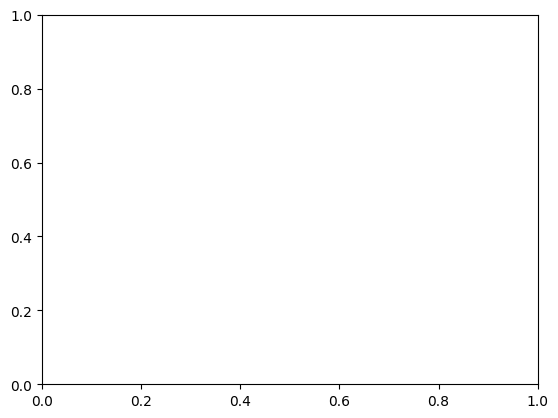

In [115]:
parameters = {
    "size": 1000,
    "seed": 123,
    "steps": 50,
    "population": 2,
    "green_duration": 10,
    "yellow_duration": 2,
    "red_duration": 8
}

animation_plot(Model, parameters)